In [48]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import numpy as np
import warnings
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
%matplotlib inline 

In [49]:
confirmed_df = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths_df = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries_df = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [50]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,989,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,400,400,410,410,411,413,414,414,418,418
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,294,294,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,102


In [51]:
cols = confirmed_df.keys()

* Get all the dates for the outbreak

In [52]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [53]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [54]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

* Future forcasting

In [55]:
days_in_future = 3
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

1. Convert integer into datetime for better visualization

In [56]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-3]

In [57]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.2, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, random forest, and linear regression in this example. 

In [58]:
kernel = ['linear', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, np.ravel(y_train_confirmed,order='C'))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1], 'shrinking': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

In [59]:
svm_search.best_params_

{'C': 10, 'epsilon': 1, 'gamma': 1, 'kernel': 'linear', 'shrinking': False}

In [60]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

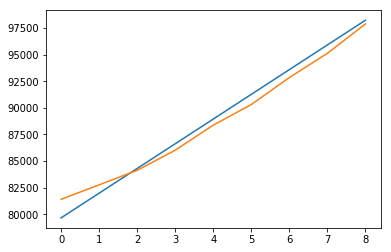

In [61]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)

In [62]:
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 7343.862111801265
MSE: 55221559.568945125


In [63]:
linear_model.coef_

array([[2464.15031056]])

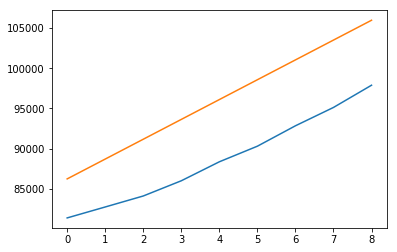

In [64]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

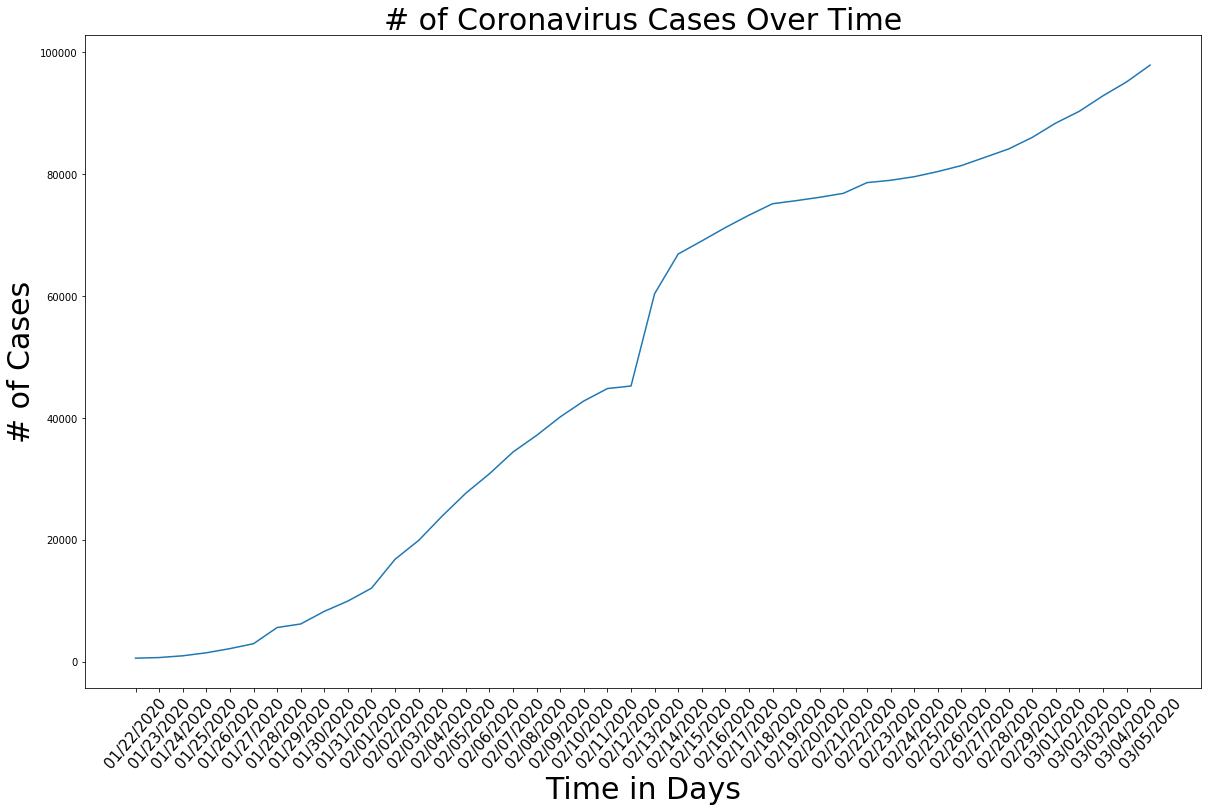

In [65]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

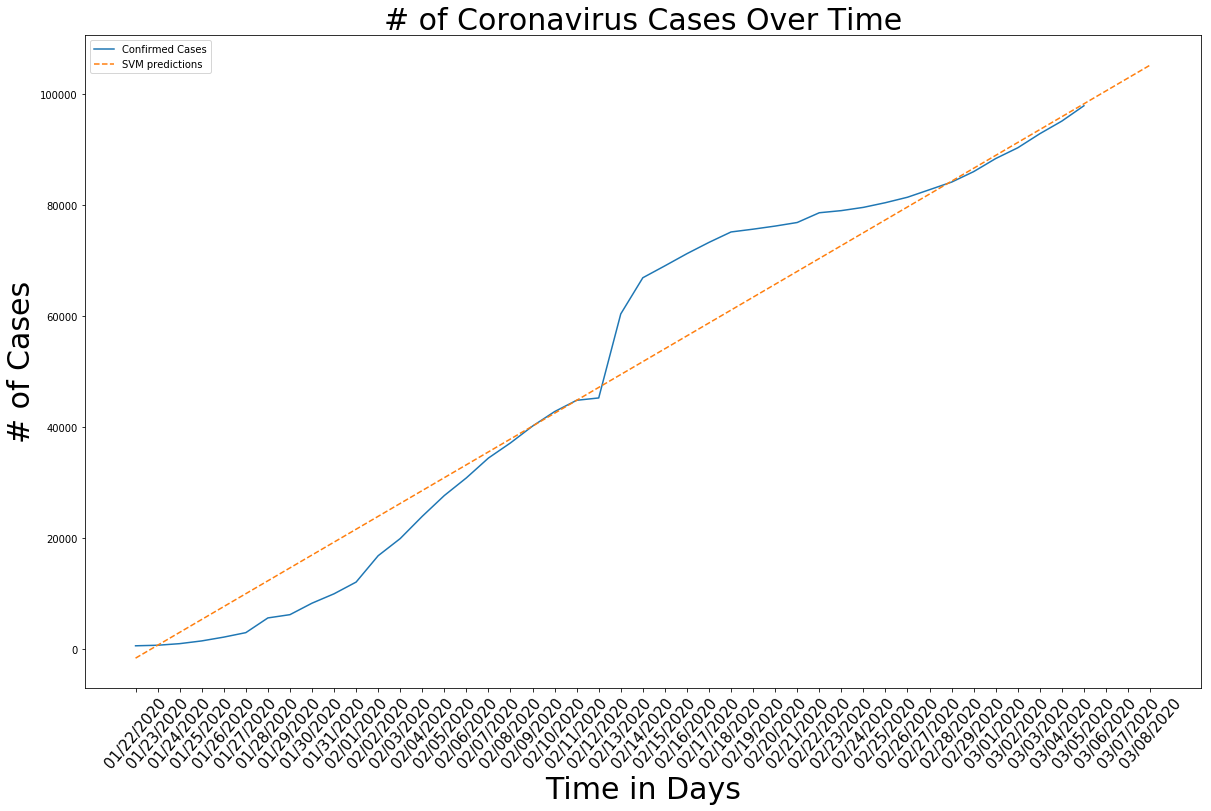

In [66]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, svm_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

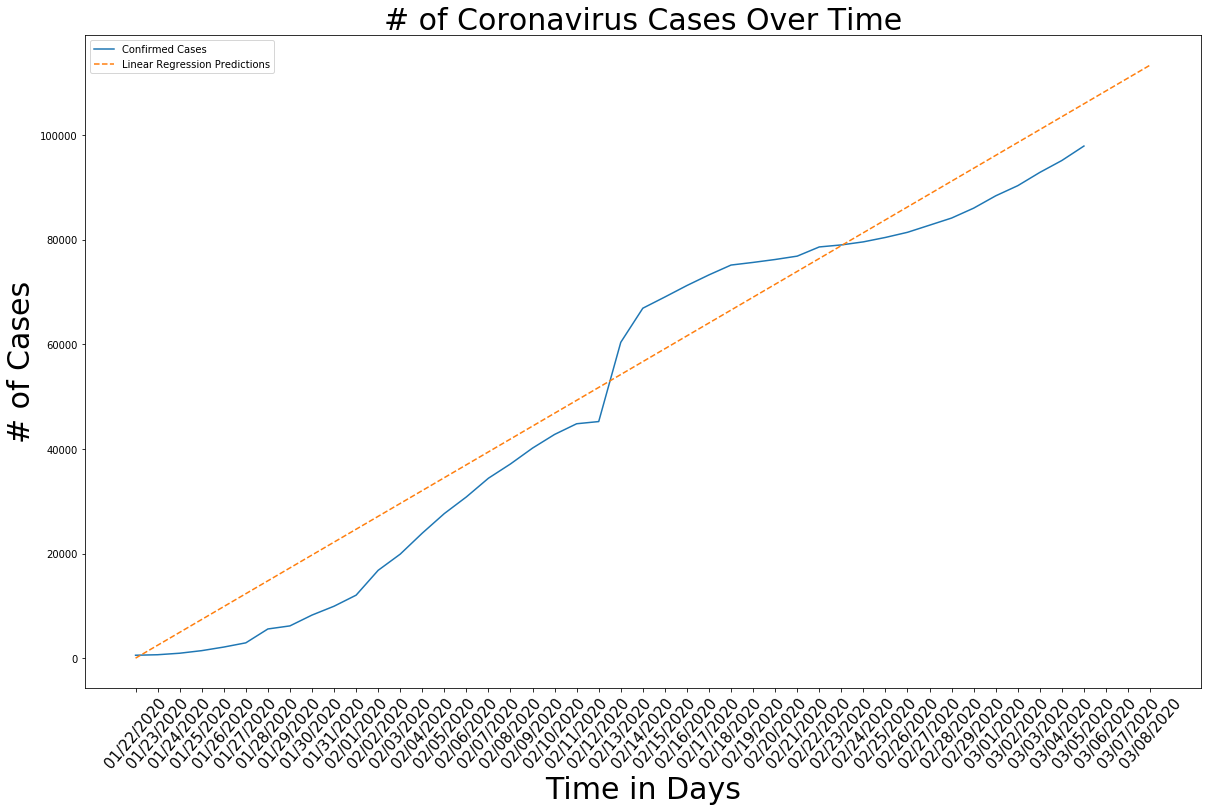

In [67]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, linear_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

In [68]:
# predictions using svm, which is the best model out of all three 
print('SVM prediction: ', set(zip(future_forcast_dates[-3:], svm_pred[-3:])))

SVM prediction:  {('03/06/2020', 100558.70588235294), ('03/07/2020', 102882.11764705883), ('03/08/2020', 105205.5294117647)}


 Graphing the number of confirmed cases, deaths, and the mortality rate over time, as well as the number of recoveries

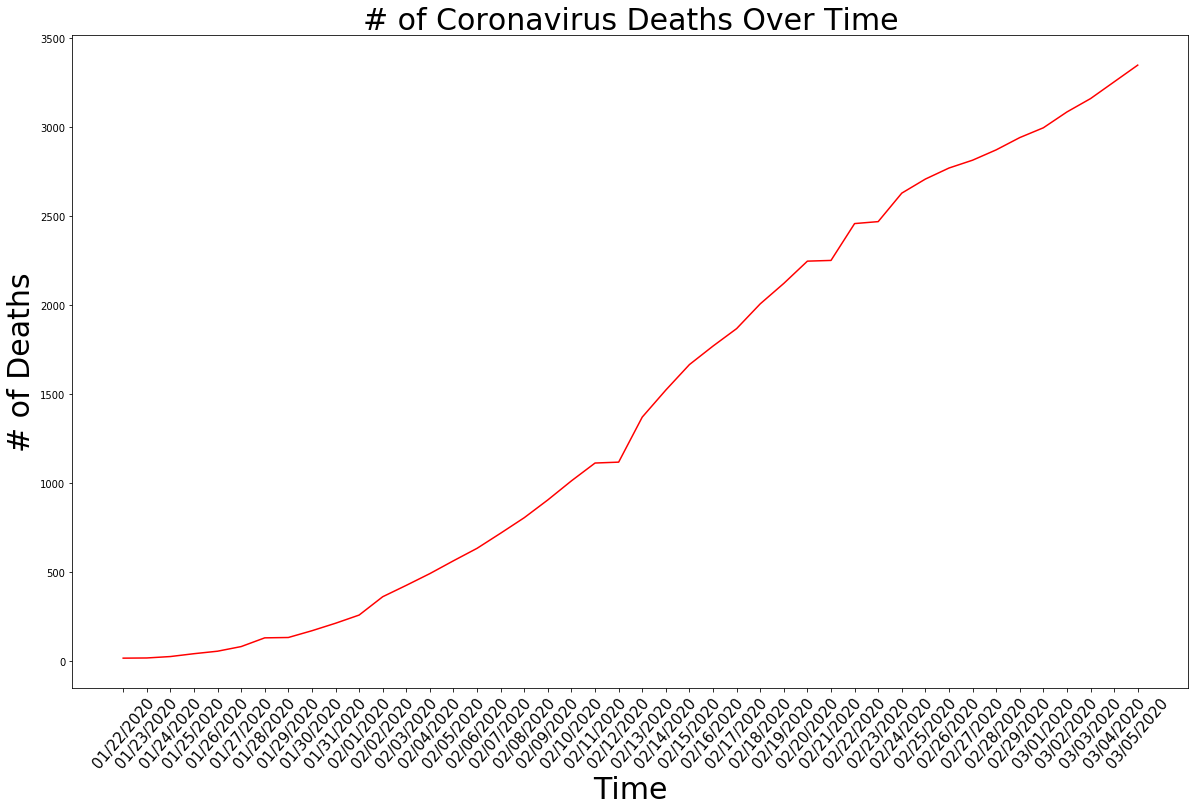

In [70]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

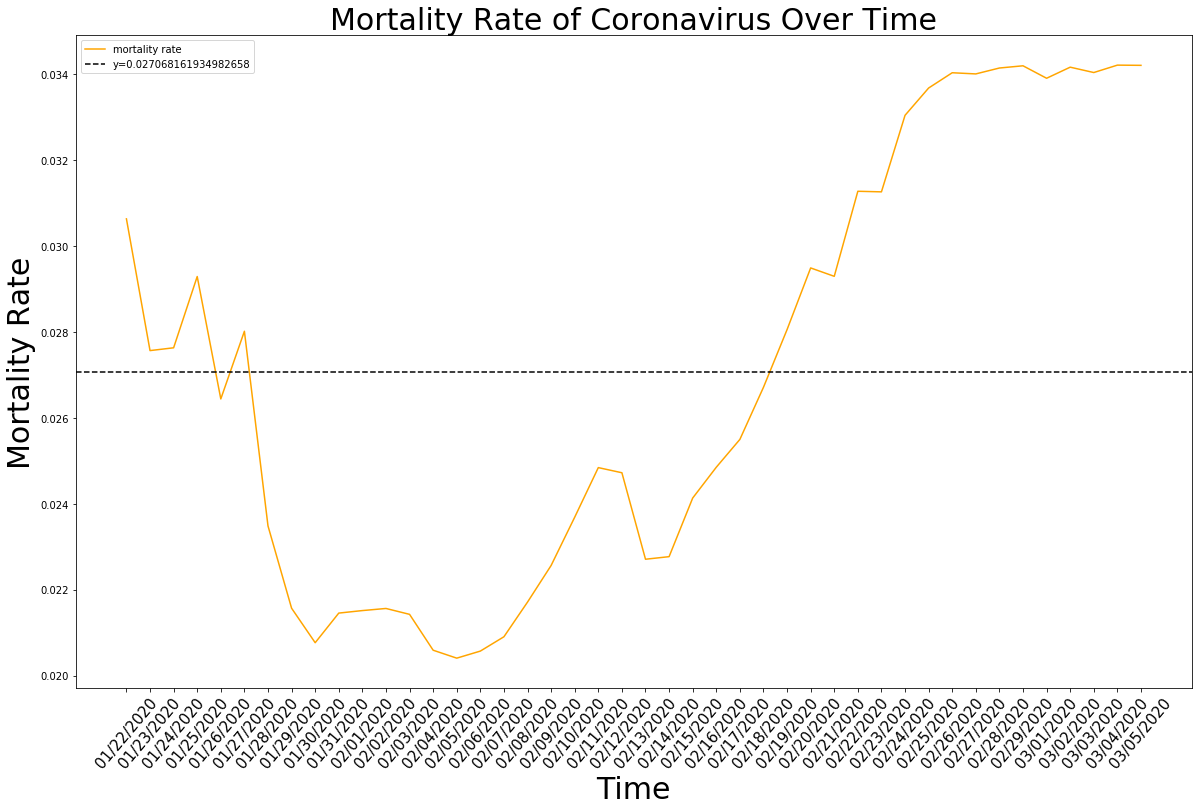

In [71]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Time', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

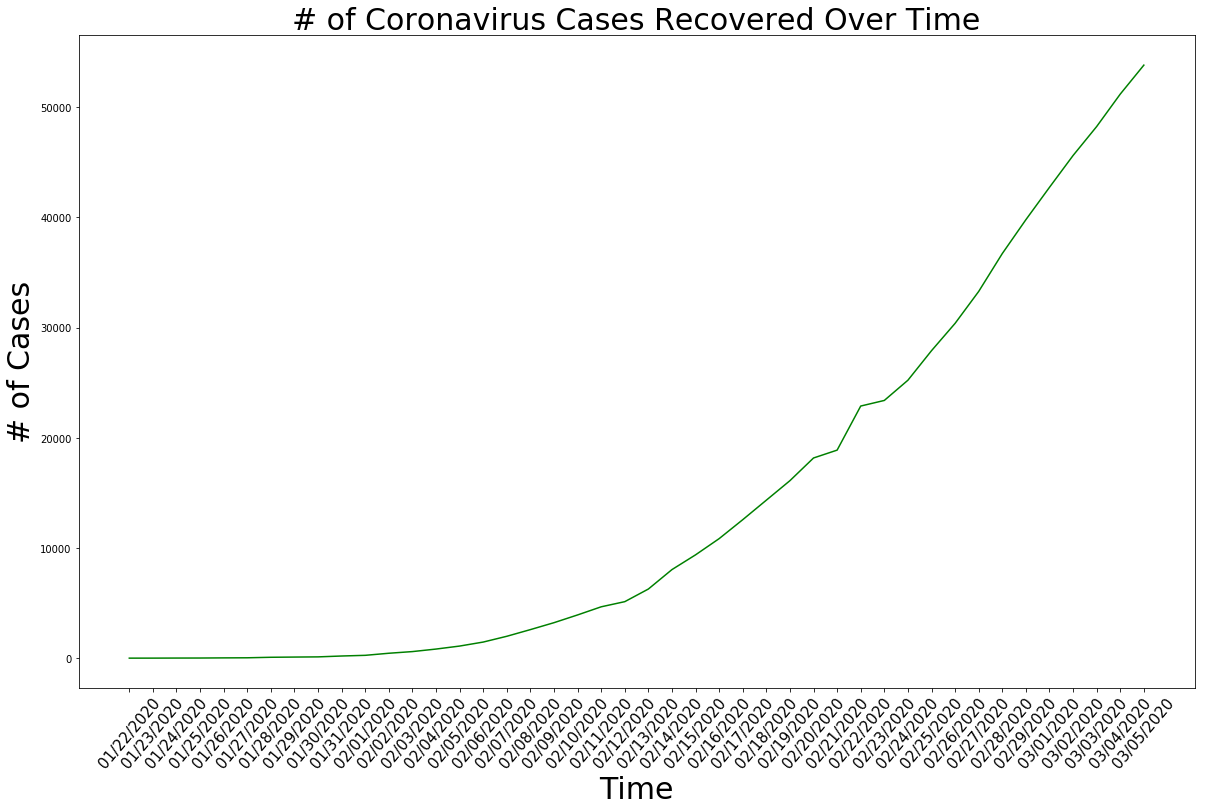

In [72]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

Graphing the number of deaths and the number of recoveries

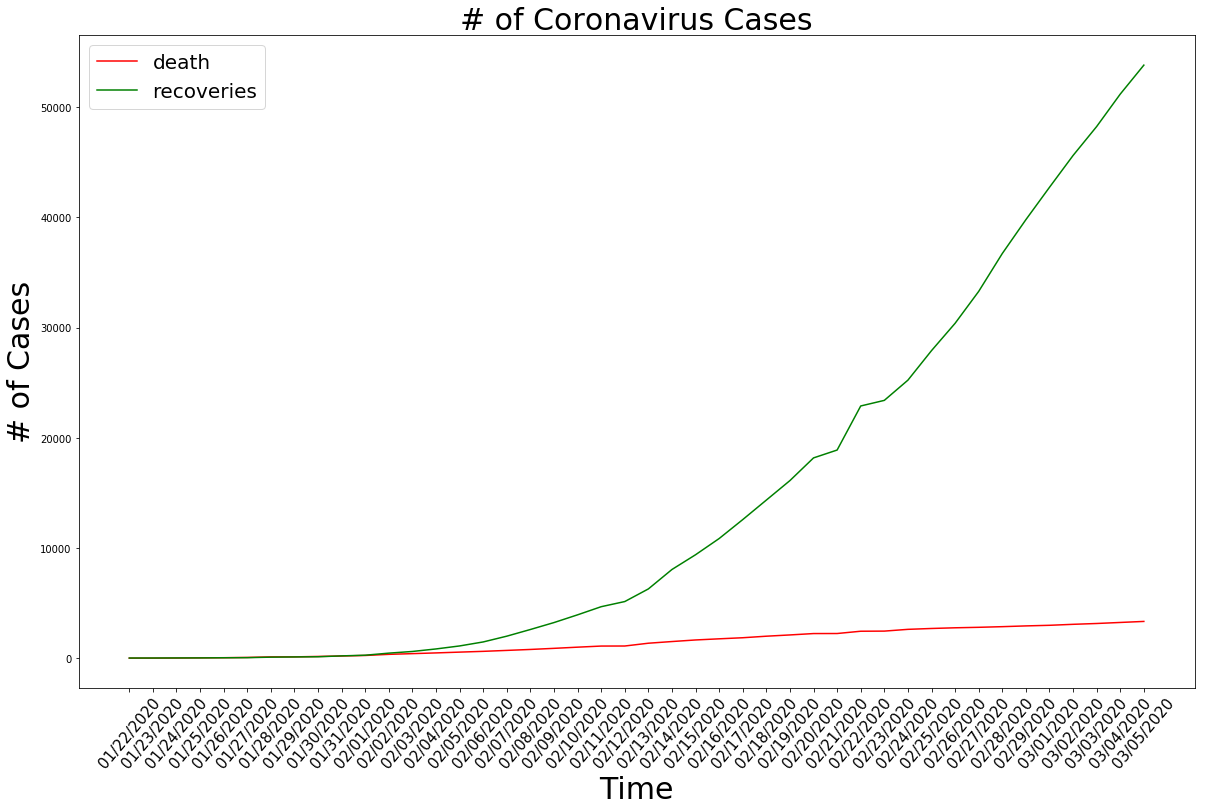

In [73]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

Plotting the number of deaths against the number of recoveries

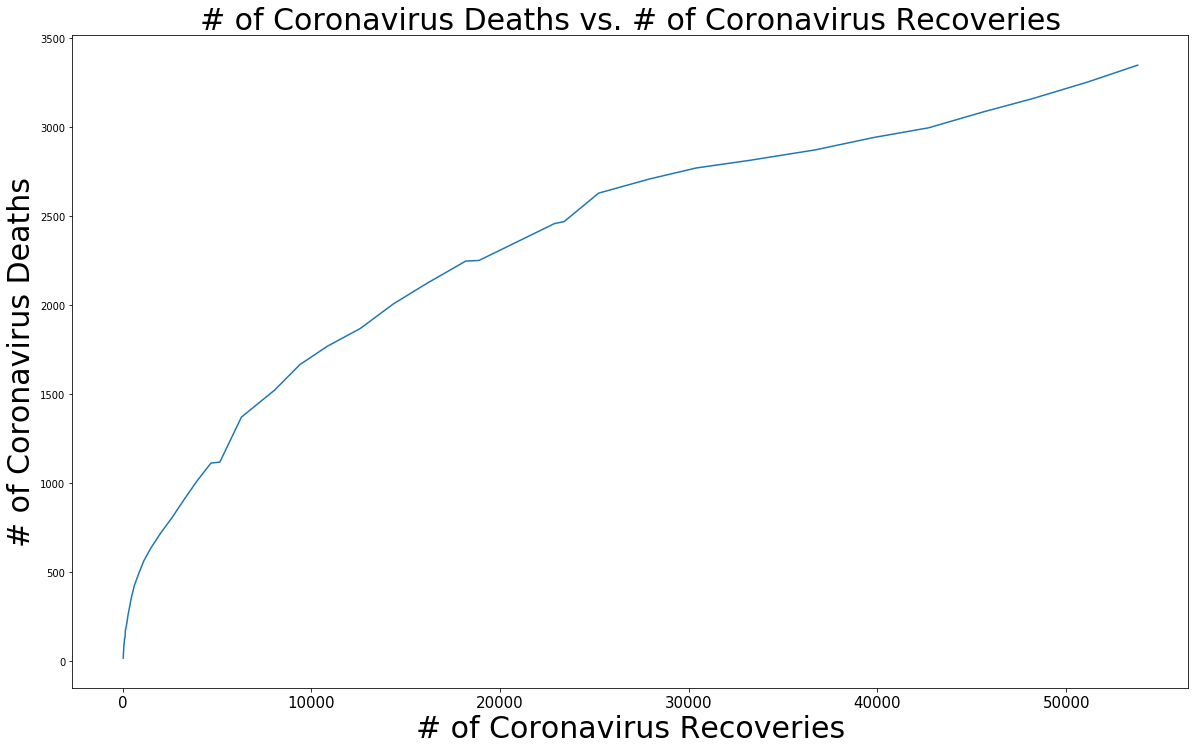

In [74]:
plt.figure(figsize=(20, 12))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=15)
plt.show()

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [75]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [76]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [77]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)

In [78]:
# number of cases per country/region
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Mainland China: 80422 cases
Thailand: 47 cases
Japan: 360 cases
South Korea: 6088 cases
Taiwan: 44 cases
US: 221 cases
Macau: 10 cases
Hong Kong: 105 cases
Singapore: 117 cases
Vietnam: 16 cases
France: 377 cases
Nepal: 1 cases
Malaysia: 50 cases
Canada: 37 cases
Australia: 55 cases
Cambodia: 1 cases
Sri Lanka: 1 cases
Germany: 482 cases
Finland: 12 cases
United Arab Emirates: 29 cases
Philippines: 3 cases
India: 30 cases
Italy: 3858 cases
UK: 115 cases
Russia: 4 cases
Sweden: 94 cases
Spain: 259 cases
Belgium: 50 cases
Others: 706 cases
Egypt: 3 cases
Iran: 3513 cases
Lebanon: 16 cases
Iraq: 35 cases
Oman: 16 cases
Afghanistan: 1 cases
Bahrain: 55 cases
Kuwait: 58 cases
Algeria: 12 cases
Croatia: 10 cases
Switzerland: 114 cases
Austria: 41 cases
Israel: 16 cases
Pakistan: 5 cases
Brazil: 4 cases
Georgia: 4 cases
Greece: 31 cases
North Macedonia: 1 cases
Norway: 87 cases
Romania: 6 cases
Denmark: 10 cases
Estonia: 3 cases
Netherlands: 82 cases
San Marino: 21 cases
Belarus: 6 cases
Icel

In [79]:
unique_provinces =  list(confirmed_df['Province/State'].unique())

In [80]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)

In [81]:
# number of cases per province/state/city

for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Anhui: 990 cases
Beijing: 418 cases
Chongqing: 576 cases
Fujian: 296 cases
Gansu: 102 cases
Guangdong: 1351 cases
Guangxi: 252 cases
Guizhou: 146 cases
Hainan: 168 cases
Hebei: 318 cases
Heilongjiang: 481 cases
Henan: 1272 cases
Hubei: 67466 cases
Hunan: 1018 cases
Inner Mongolia: 75 cases
Jiangsu: 631 cases
Jiangxi: 935 cases
Jilin: 93 cases
Liaoning: 125 cases
Ningxia: 75 cases
Qinghai: 18 cases
Shaanxi: 245 cases
Shandong: 758 cases
Shanghai: 339 cases
Shanxi: 133 cases
Sichuan: 539 cases
Tianjin: 136 cases
Tibet: 1 cases
Xinjiang: 76 cases
Yunnan: 174 cases
Zhejiang: 1215 cases
Taiwan: 44 cases
King County, WA: 51 cases
Cook County, IL: 5 cases
Tempe, AZ: 1 cases
Macau: 10 cases
Hong Kong: 105 cases
Toronto, ON: 21 cases
British Columbia: 13 cases
Los Angeles, CA: 11 cases
New South Wales: 22 cases
Victoria: 10 cases
Queensland: 13 cases
London, ON: 1 cases
Santa Clara, CA: 20 cases
South Australia: 5 cases
Boston, MA: 1 cases
San Benito, CA: 2 cases
Madison, WI: 1 cases
Diamond Pr

In [82]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

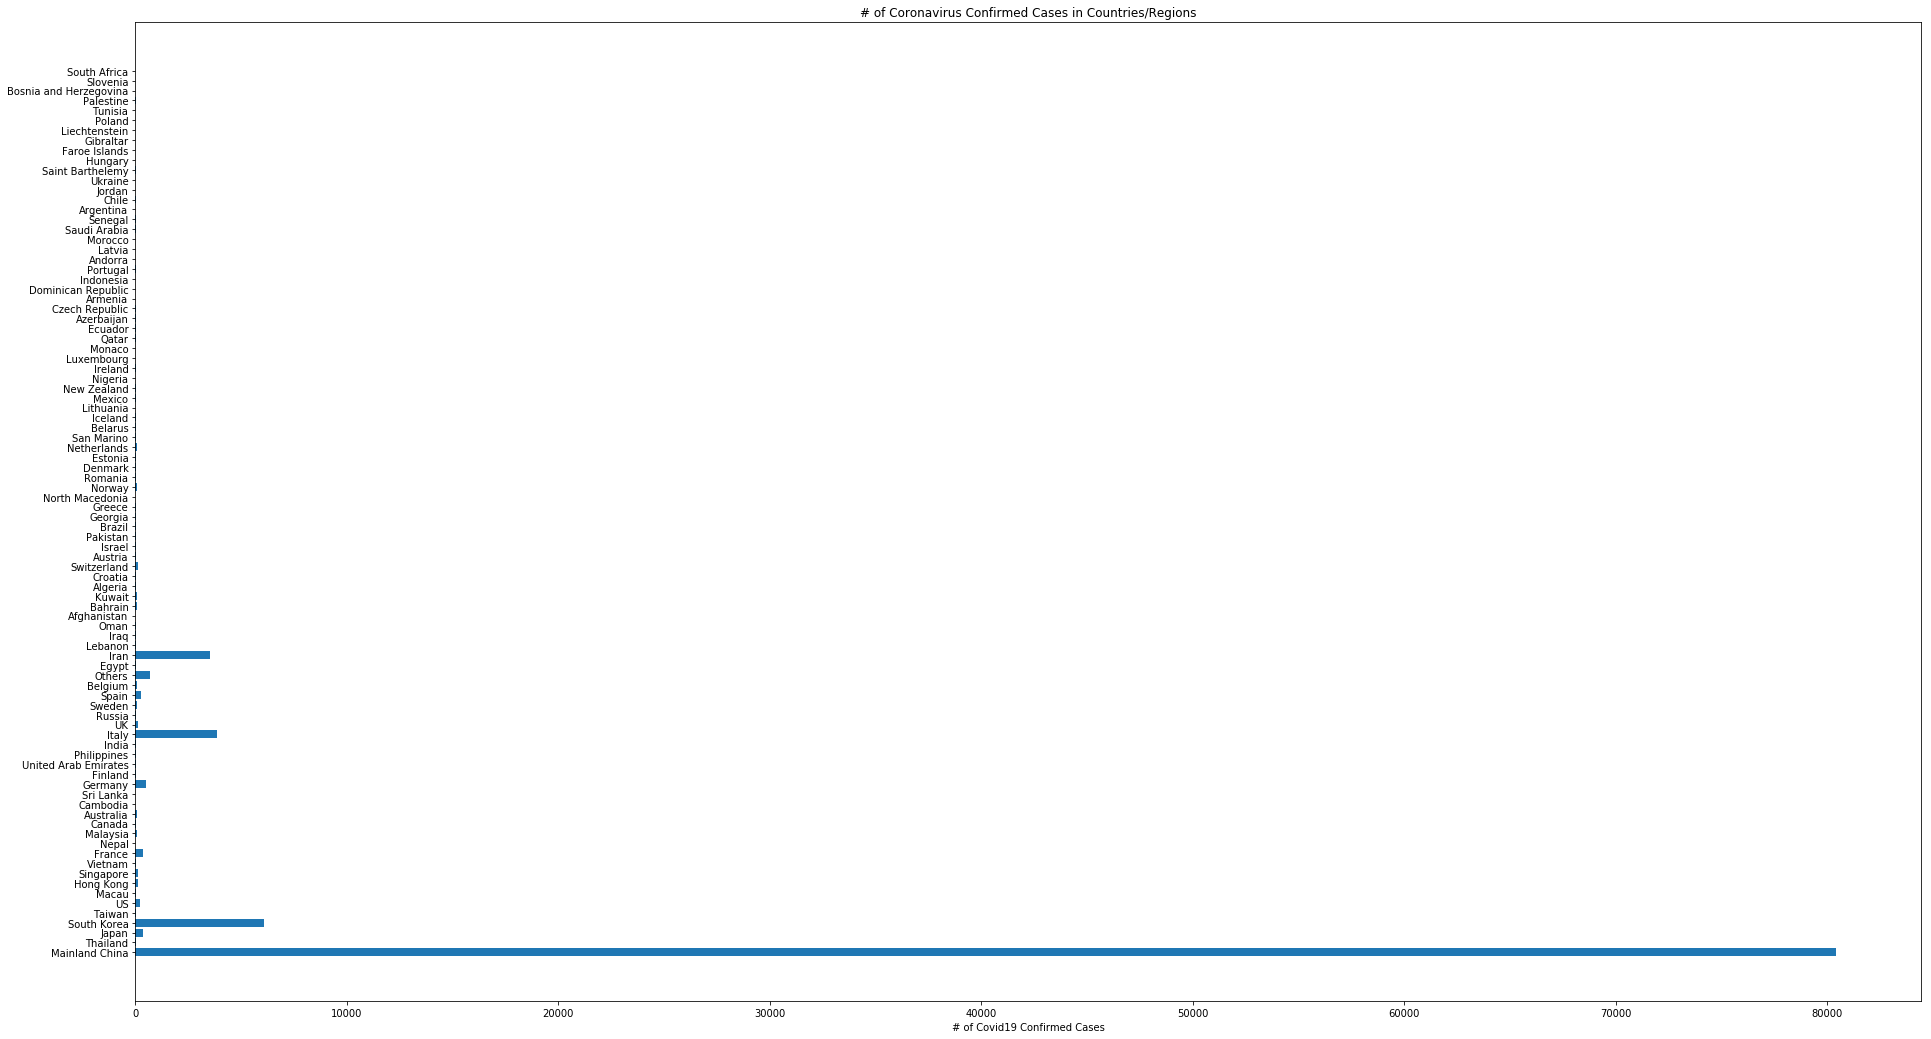

In [83]:
plt.figure(figsize=(32, 18))
plt.barh(unique_countries, country_confirmed_cases)
plt.title('# of Coronavirus Confirmed Cases in Countries/Regions')
plt.xlabel('# of Covid19 Confirmed Cases')
plt.show()

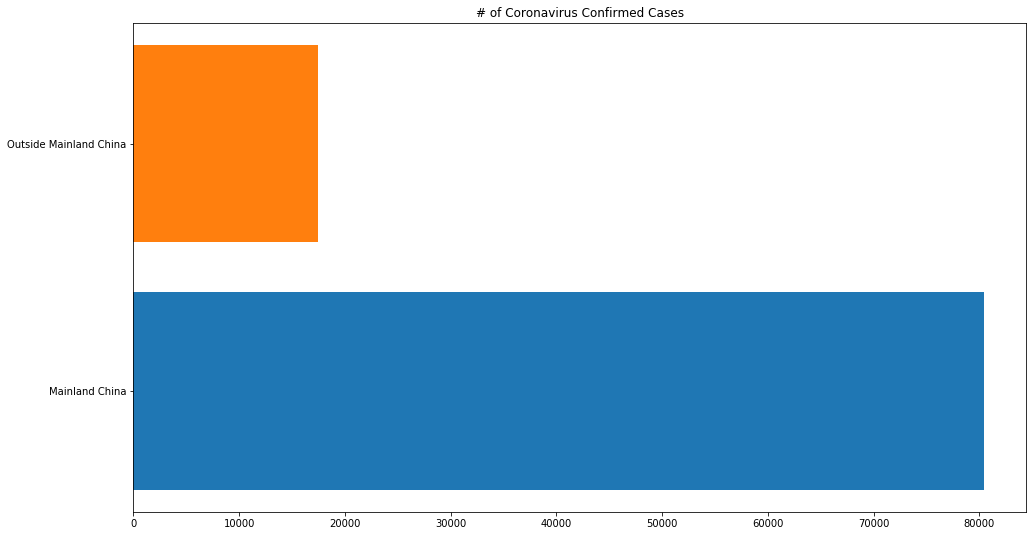

In [84]:
outside_mainland_china_confirmed = np.sum(country_confirmed_cases[1:])
plt.figure(figsize=(16, 9))
plt.barh(unique_countries[0], country_confirmed_cases[0])
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()

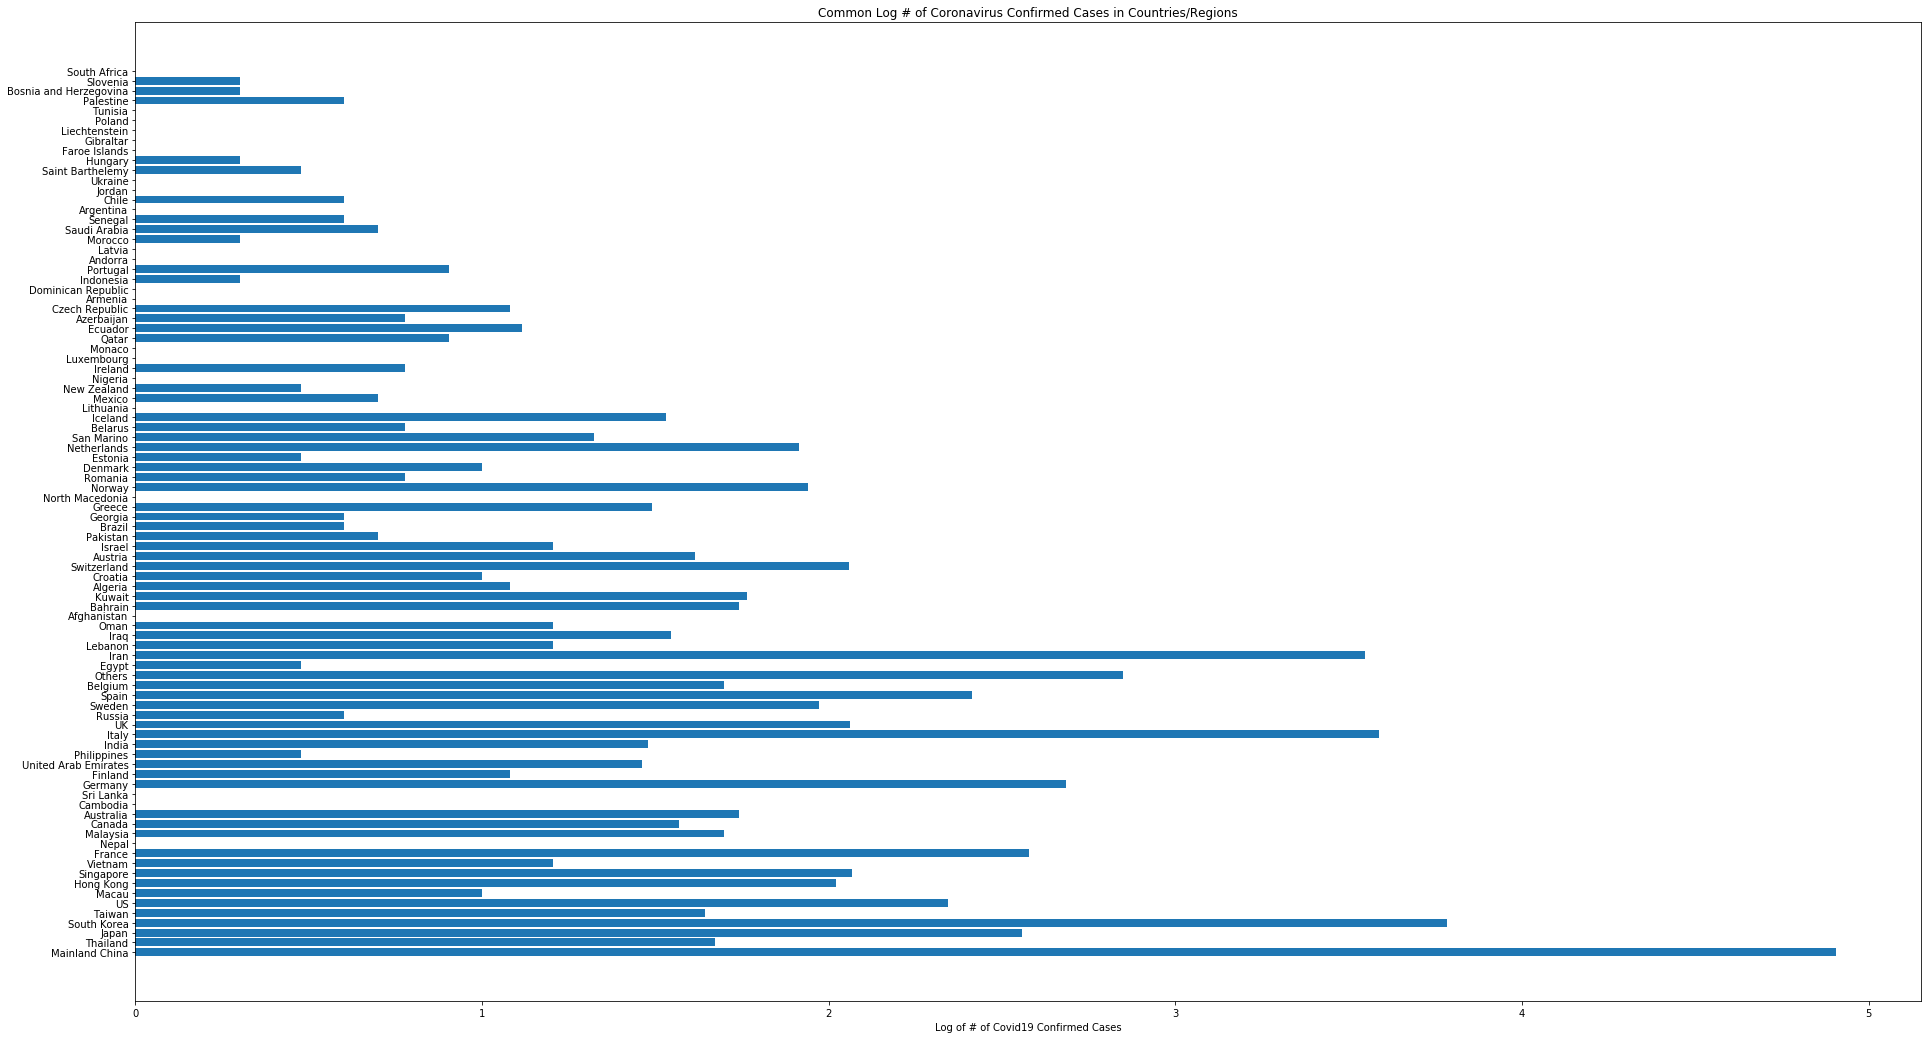

In [85]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in country_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(unique_countries, log_country_confirmed_cases)
plt.title('Common Log # of Coronavirus Confirmed Cases in Countries/Regions')
plt.xlabel('Log of # of Covid19 Confirmed Cases')
plt.show()

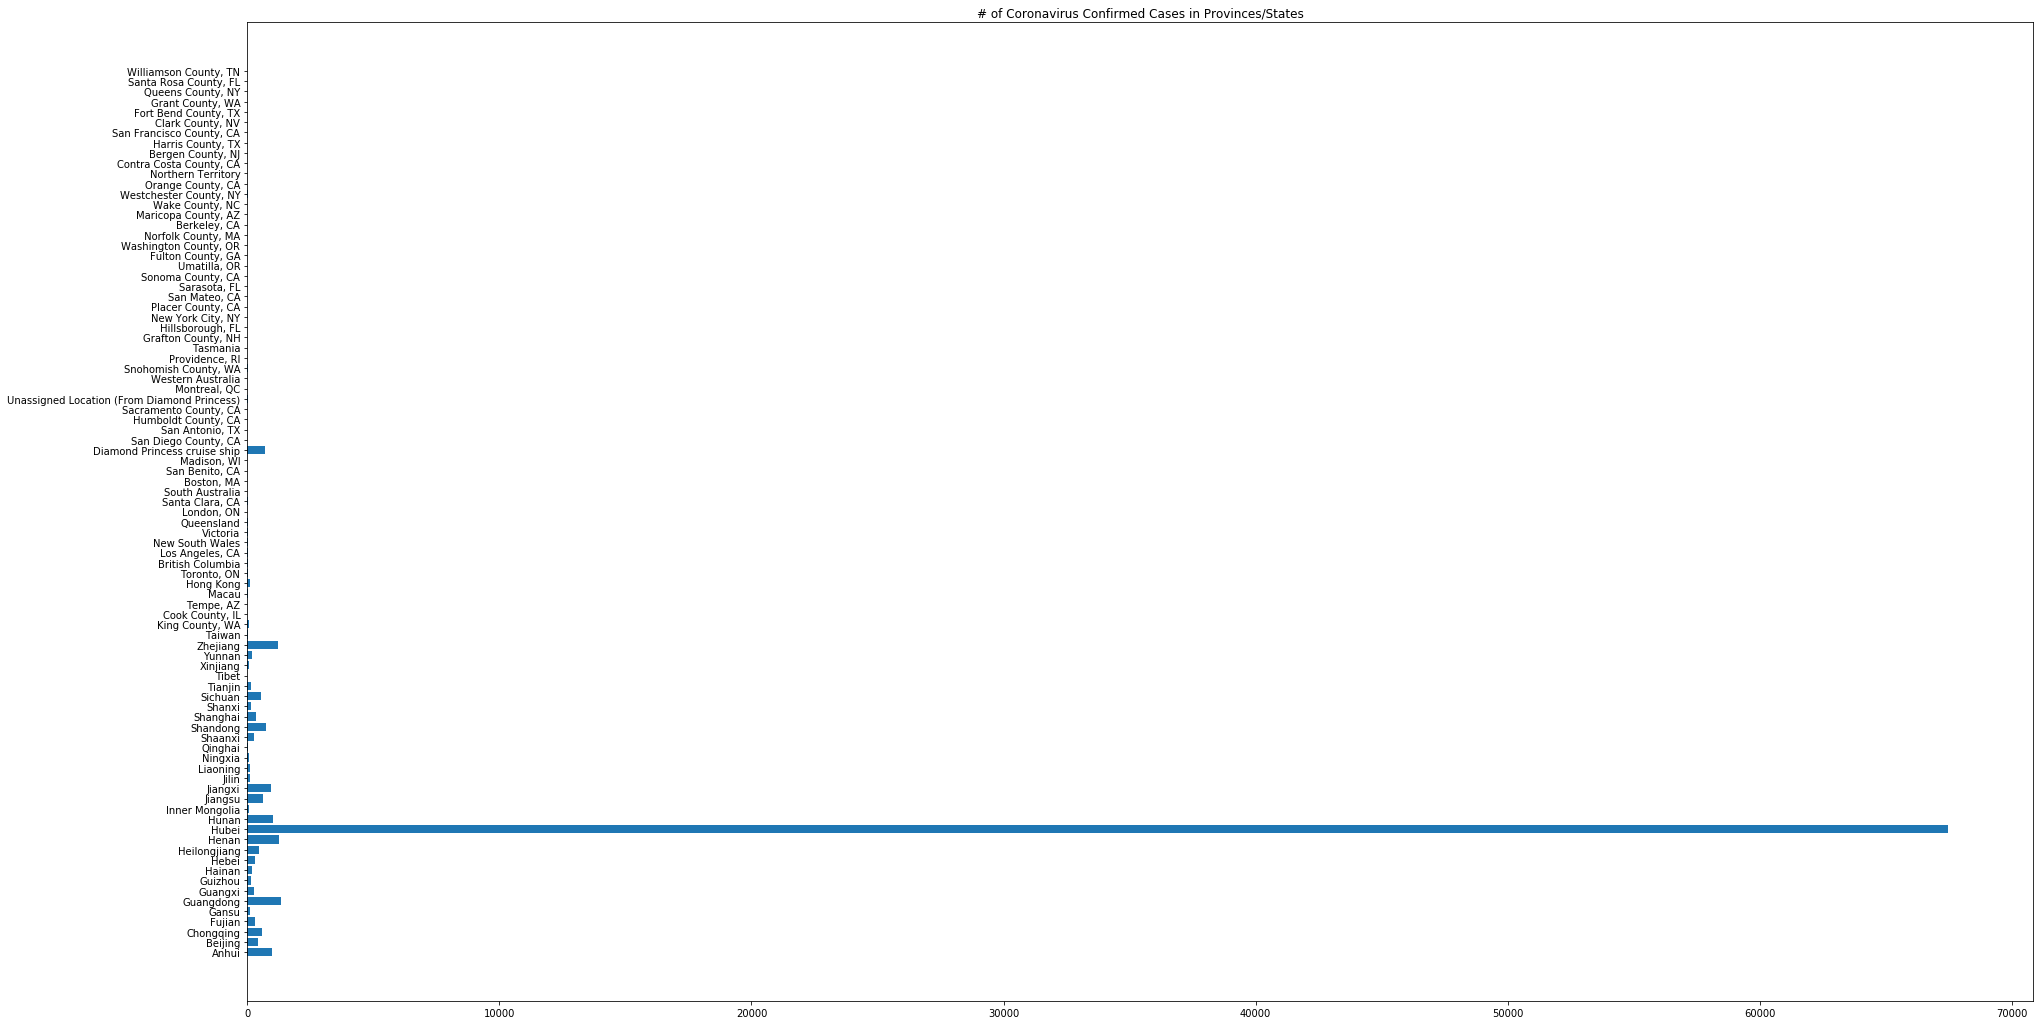

In [86]:
plt.figure(figsize=(32, 18))
plt.barh(unique_provinces, province_confirmed_cases)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States')
plt.show()

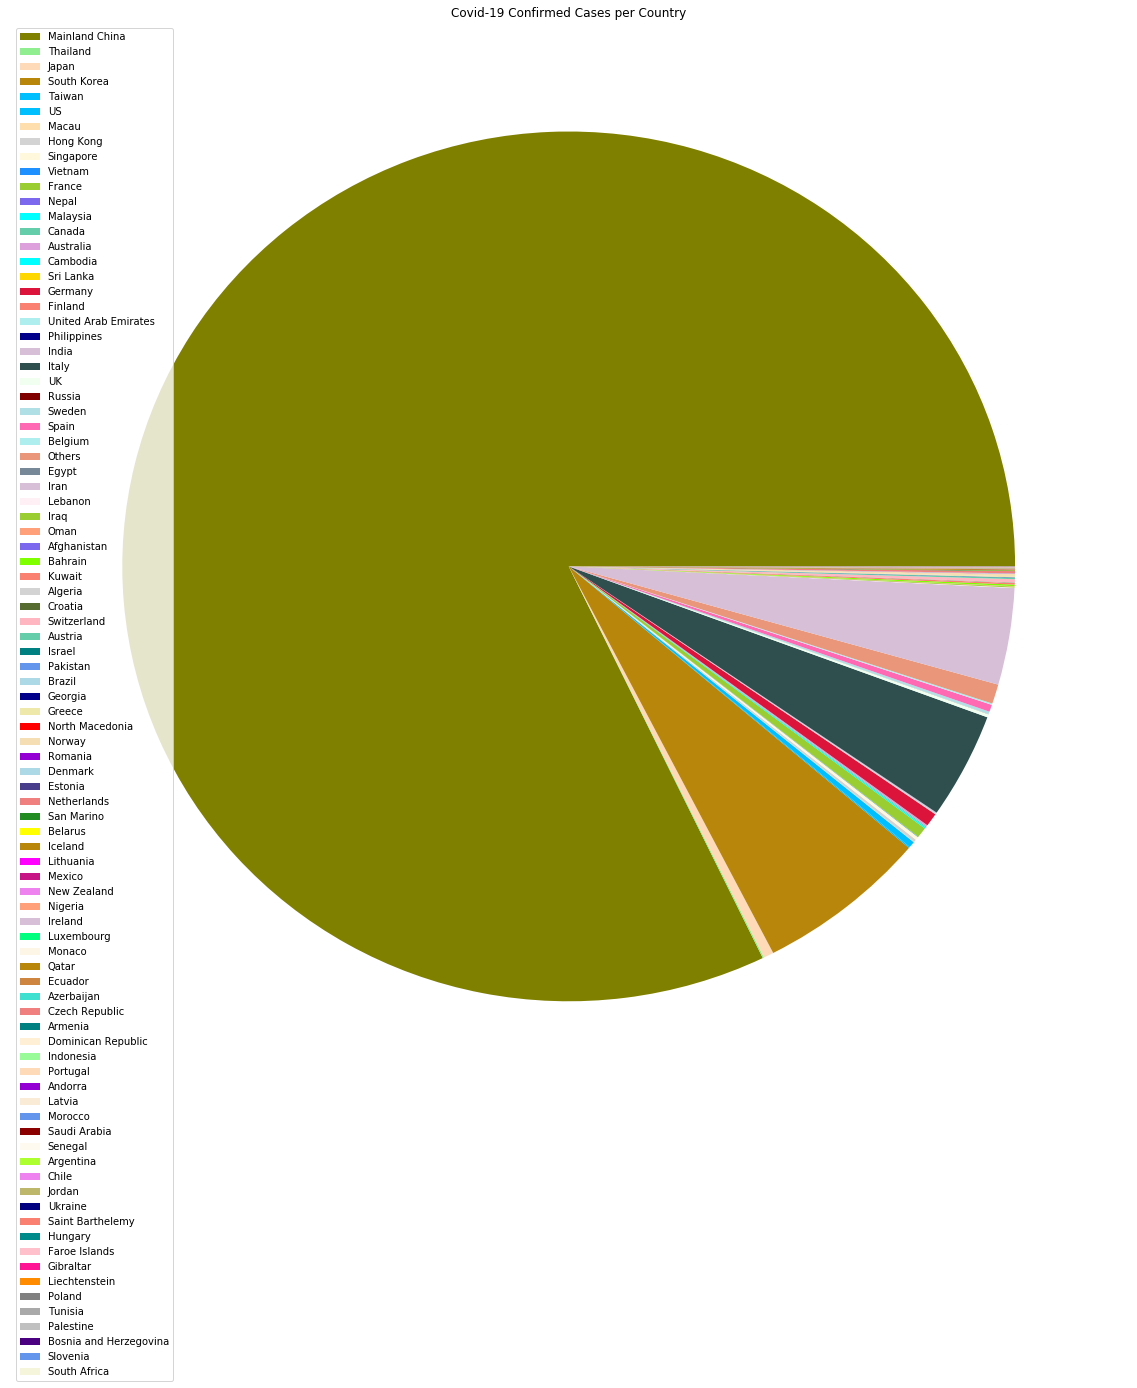

In [87]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(country_confirmed_cases, colors=c)
plt.legend(unique_countries, loc='best')
plt.show()

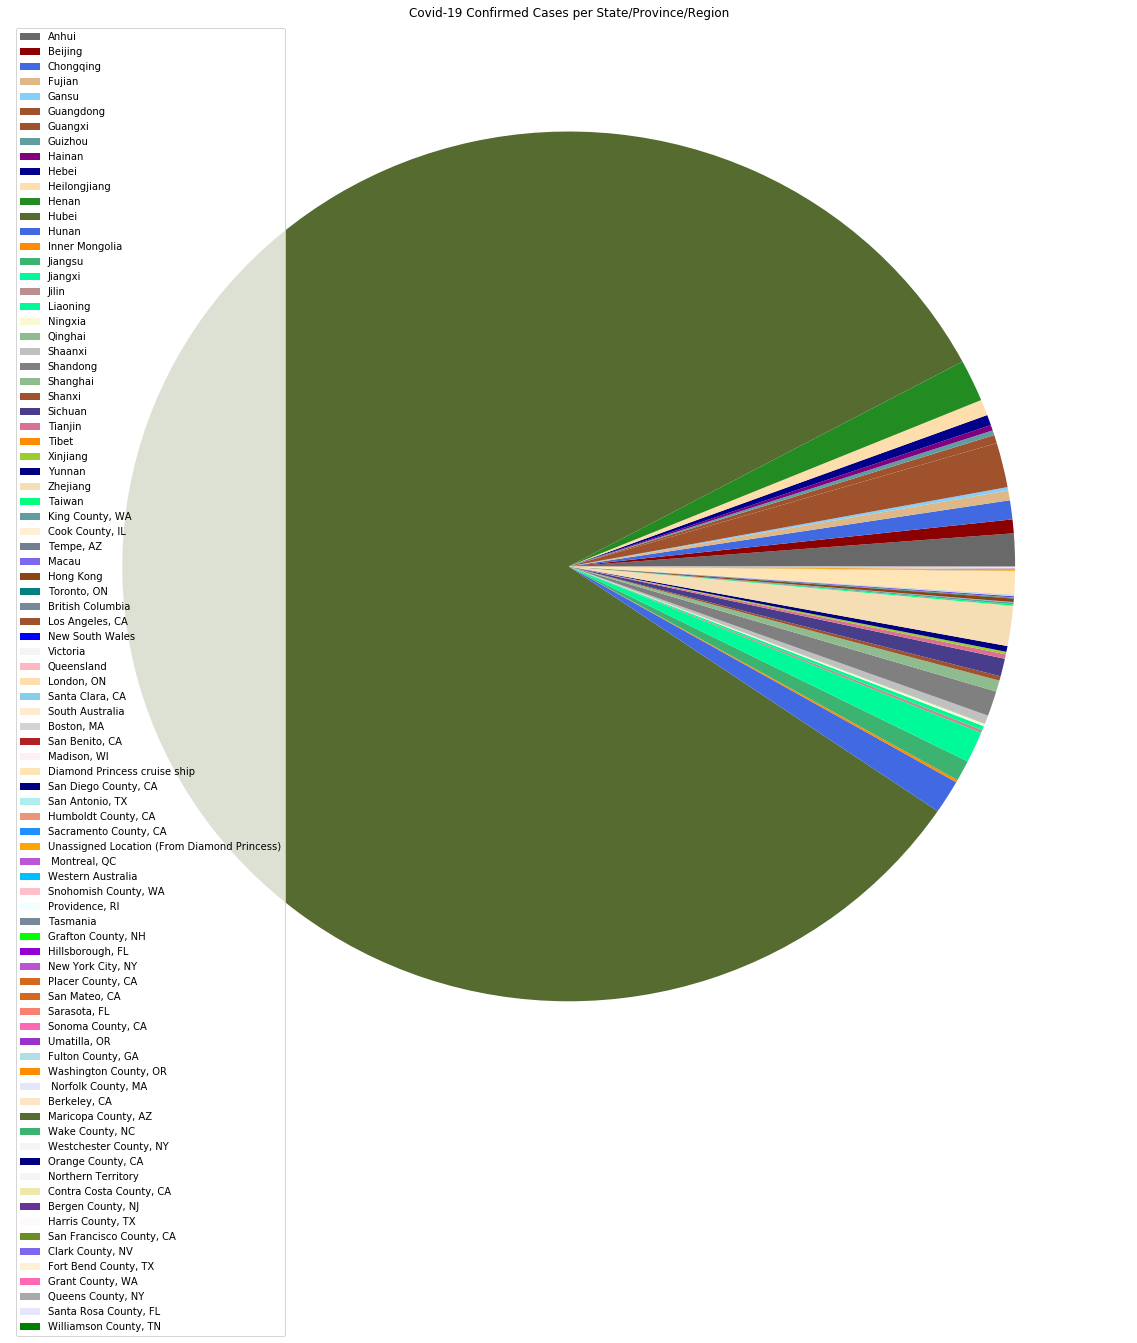

In [88]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per State/Province/Region')
plt.pie(province_confirmed_cases, colors=c)
plt.legend(unique_provinces, loc='best')
plt.show()

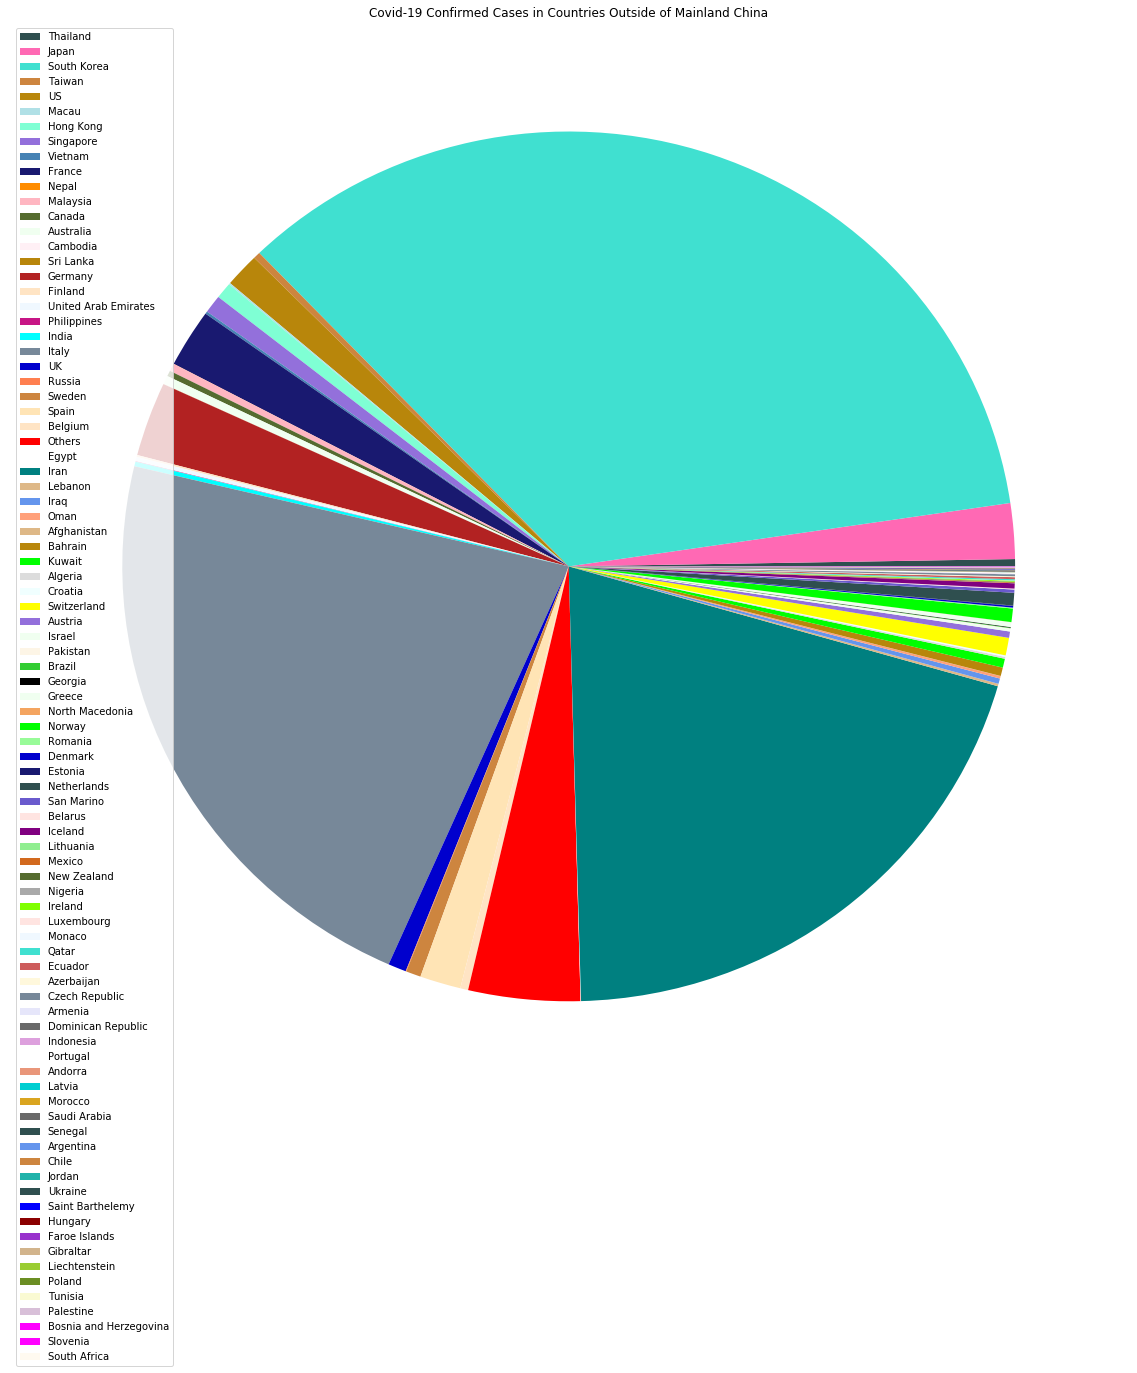

In [89]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(country_confirmed_cases[1:], colors=c)
plt.legend(unique_countries[1:], loc='best')
plt.show()